<a href="https://colab.research.google.com/github/valering97/real-estate-market-model/blob/main/ModelRealEstateMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Prediction model for a real estate market***

In [ ]:
%cd /content/

/content


In [ ]:
!rm -rf *

In [ ]:
!git clone https://github.com/valering97/real-estate-market-model.git

Cloning into 'real-estate-market-model'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 17.99 KiB | 472.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
%cd real-estate-market-model

/content/real-estate-market-model


In [ ]:
#!git pull origin main

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from src.constants import RANDOM_SEED
from src import data_processing
from src import models
from src import results

# ***Data Preprocessing***


*   Importing dataset to analyze
*  Check for duplicates and missing values

In [ ]:
# Import Dataset
df = pd.read_csv("dataset/housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


In [ ]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (545, 13)


We noticed that ['bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'] have discrete values. If these influence the target price in a non-proportional way, it would be useful to consider these features as categorical.

In [ ]:
# Distribution for categorical features compared with price target
for feature in ['bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'] :
    data_processing.plot_categorical_with_target(df, feature, target='price')

I exclude binary features

In [ ]:
# Convert categorical features from int64 to category
exclude_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
columns_to_cat = df.columns[2:]
columns_to_transform = [col for col in columns_to_cat if col not in exclude_columns]
cat_features = list(columns_to_transform)
df_categorical = data_processing.convert_to_category(df, cat_features)
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             545 non-null    int64   
 1   area              545 non-null    int64   
 2   bedrooms          545 non-null    category
 3   bathrooms         545 non-null    category
 4   stories           545 non-null    category
 5   mainroad          545 non-null    int64   
 6   guestroom         545 non-null    int64   
 7   basement          545 non-null    int64   
 8   hotwaterheating   545 non-null    int64   
 9   airconditioning   545 non-null    int64   
 10  parking           545 non-null    category
 11  prefarea          545 non-null    int64   
 12  furnishingstatus  545 non-null    category
dtypes: category(5), int64(8)
memory usage: 37.8 KB


In [ ]:
# Remove duplicates if exist

df_cleaned = data_processing.handle_duplicates(df_categorical)

No duplicates found!


In [ ]:
# Handling missing values

df_cleaned.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


# ***Feature Engineering***

*  Function to do One-Hot Encoding on the categorical features
*  Splitting dataset into training and test using train_test_split()
*  Feature Scaling with Standardization using a fit_transform with X_train and just transform the X_test





In [ ]:
# Dummy Encoding for categorical features with unique value greater than 2
df_encoded = data_processing.apply_encoding(df_cleaned)
df_encoded.head()

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,bedrooms_2,bedrooms_3,...,bathrooms_3,bathrooms_4,stories_2,stories_3,stories_4,parking_1,parking_2,parking_3,furnishingstatus_1,furnishingstatus_2
0,13300000,7420,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,1,0
1,12250000,8960,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
2,12250000,9960,1,0,1,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,1
3,12215000,7500,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
4,11410000,7420,1,1,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [ ]:
# Splitting dataset into training and test

X = df_encoded.drop(columns=['price'])
y = df_encoded.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

print(f'Dataset Shape: {df_encoded.shape}')
print(f'Training Shape: {X_train.shape}')
print(f'Test Shape: {X_test.shape}')

Dataset Shape: (545, 24)
Training Shape: (381, 23)
Test Shape: (164, 23)


In [ ]:
# Feature Scaling with Standardization

X_train_scaled, X_test_scaled = data_processing.feature_scaling_standardization(X_train, X_test)

# ***Regression Models Implementation***

*   Implementation and training for these models: Linear Regression, Ridge (L2 Regolation), Lasso (L1 Regolation), ElasticNet(L1+L2)




In [ ]:
# Training models

linear_model = models.train_model(X_train, y_train, model_type='linear')

ridge_model = models.train_model(X_train, y_train, model_type='ridge', alpha=1.0)

lasso_model = models.train_model(X_train, y_train, model_type='lasso', alpha=1.0)

elasticnet_model = models.train_model(X_train, y_train, model_type='elasticnet', alpha=1.0, l1_ratio = 0.5)

Comparing the metrics on training and test sets, we can diagnose:  

- **Overfitting**:  
Good performance on the training set but poor performance on the test set. For example, low MSE on training but high MSE on test.  

- **Underfitting**:  
Poor performance on both sets (the model is too simple or improperly configured). For example, high MSE on both training and test sets.  

In [ ]:
# Evaluate models performance

print("-"*60)
print("Linear Regression Model:")
models.evaluate_model(ridge_model, X_test, y_test, X_train, y_train)

print("-"*60)
print("Ridge Regression Model:")
models.evaluate_model(ridge_model, X_test, y_test, X_train, y_train)

print("-"*60)
print("Lasso Regression Model:")
models.evaluate_model(lasso_model, X_test, y_test, X_train, y_train)

print("-"*60)
print("ElasticNet Regression Model:")
models.evaluate_model(elasticnet_model, X_test, y_test, X_train, y_train)
print("-"*60)

------------------------------------------------------------
Linear Regression Model:
Mean Squared Error for Training set: 952597981042.75
R^2 Score for Training set: 0.6968
Mean Squared Error for Test set: 1577858874879.80
R^2 Score for Test set: 0.6336
------------------------------------------------------------
Ridge Regression Model:
Mean Squared Error for Training set: 952597981042.75
R^2 Score for Training set: 0.6968
Mean Squared Error for Test set: 1577858874879.80
R^2 Score for Test set: 0.6336
------------------------------------------------------------
Lasso Regression Model:
Mean Squared Error for Training set: 931986366686.55
R^2 Score for Training set: 0.7033
Mean Squared Error for Test set: 1634381547309.32
R^2 Score for Test set: 0.6205
------------------------------------------------------------
ElasticNet Regression Model:
Mean Squared Error for Training set: 1547809410323.97
R^2 Score for Training set: 0.5073
Mean Squared Error for Test set: 2386337532747.44
R^2 Scor

- **LinearRegression**:  
The MSE on the test set is much higher than on the training set, indicating a loss of precision in generalization.  
The R² score is decent for both sets (69.68% on training and 63.36% on test), suggesting that the model explains a good portion of the variance in the data.  
There is slight overfitting: the model performs better on the training data than on the test data.  

- **Ridge**:  
Ridge produces results identical to standard linear regression. This is likely because the regularization parameter α for Ridge is too low, making regularization practically negligible. Overfitting is present, as in the case of linear regression.  

- **Lasso**:  
Lasso slightly improves on linear regression and Ridge.  
Lower MSE on both training and test sets.  
Slightly higher R² score (70.33% on training and 62.05% on test). This suggests that Lasso has successfully regularized the model slightly better by eliminating less relevant coefficients.  

- **ElasticNet**:  
ElasticNet shows significantly worse performance compared to the other models.  
Higher MSE on both training and test sets.  
Lower R² score (50.73% on training and 44.59% on test).  

# ***Performance Evaluation***


*  K-folds Cross-Validation
*   Evaluating models with Mean Squared Error (MSE) and R2 score
*   Models Complexity comparison with Non-Zero Coefficients (results cross-validated)




In [ ]:
# Model evaluation in Cross-Validation

model_types = ['linear', 'ridge', 'lasso', 'elasticnet']

kFoldResults, y_true_pred = models.evaluate_models_with_kfold(X, y, model_types, k = 5, alpha=0.1, l1_ratio=0.5)

------------------------------
Evaluating Fold 1:
Training linear model...
Training ridge model...
Training lasso model...
Training elasticnet model...
------------------------------
------------------------------
Evaluating Fold 2:
Training linear model...
Training ridge model...
Training lasso model...
Training elasticnet model...
------------------------------
------------------------------
Evaluating Fold 3:
Training linear model...
Training ridge model...
Training lasso model...
Training elasticnet model...
------------------------------
------------------------------
Evaluating Fold 4:
Training linear model...
Training ridge model...
Training lasso model...
Training elasticnet model...
------------------------------
------------------------------
Evaluating Fold 5:
Training linear model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.458e+13, tolerance: 1.598e+11



Training ridge model...
Training lasso model...
Training elasticnet model...
------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.350e+13, tolerance: 1.519e+11



In [ ]:
# Plot summary for metric ['mse', 'r2', 'rmse']
fig, summary_df = models.plot_metric_summary(kFoldResults, metric='mse')

fig.show()

In [ ]:
# Models complexity with non zero coefficients
models.plot_model_complexity(kFoldResults)

# ***Result Visualization***

***Results comparison about models cross-validated performances***


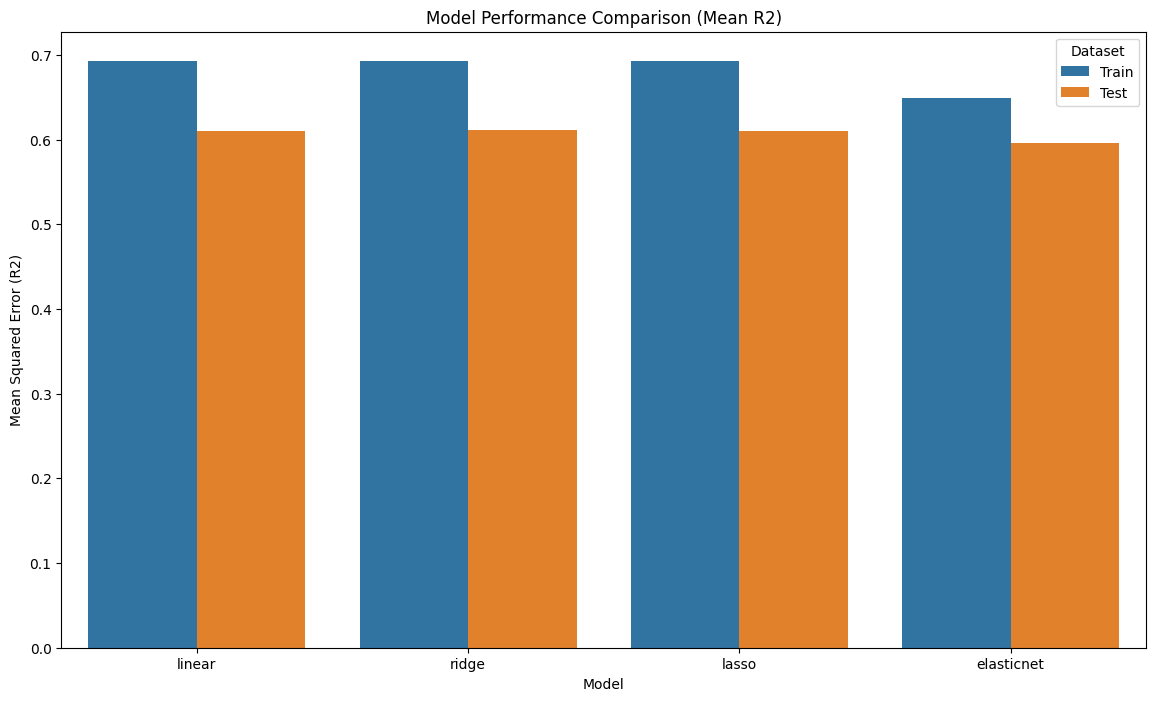

In [ ]:
# Bar Plot to view models performances
# metric ['mse', 'r2', 'rmse']
summary_df = results.plot_model_performance(kFoldResults, metric='r2')

In [ ]:
summary_df

,Model,Dataset,Mean_R2,Std_R2
0,linear,Train,0.692789,0.006015
1,linear,Test,0.610515,0.068234
2,ridge,Train,0.692628,0.006039
3,ridge,Test,0.611335,0.068798
4,lasso,Train,0.692789,0.006015
5,lasso,Test,0.610515,0.068235
6,elasticnet,Train,0.649522,0.009622
7,elasticnet,Test,0.596374,0.066203


The residuals represent the difference between the values ​​predicted by the model and the actual values. The distribution of residuals should ideally follow a normal distribution and have a mean close to 0.

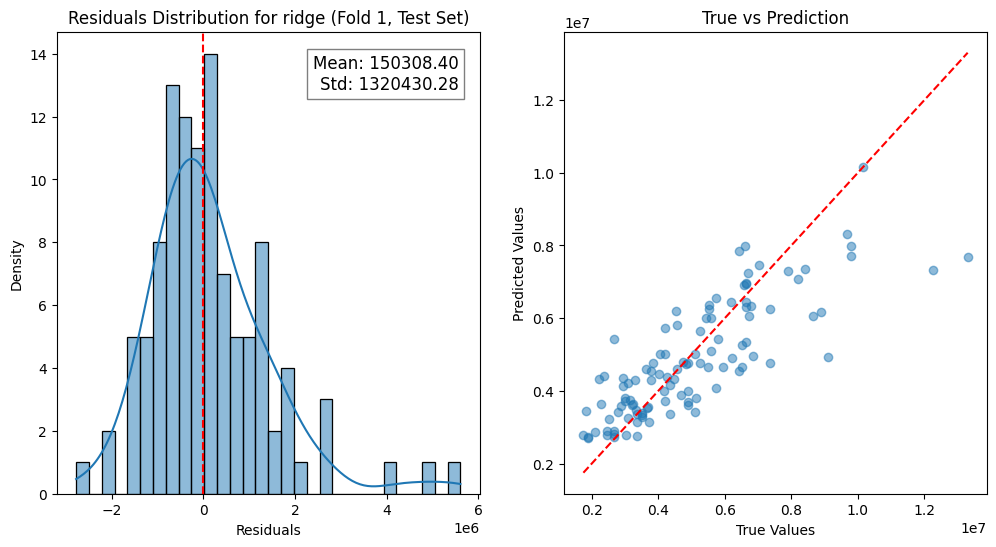

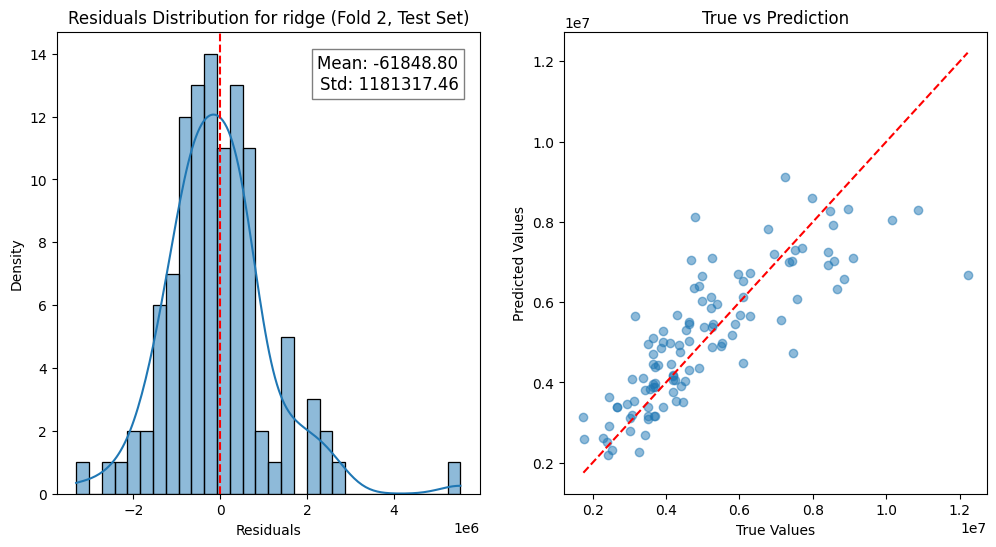

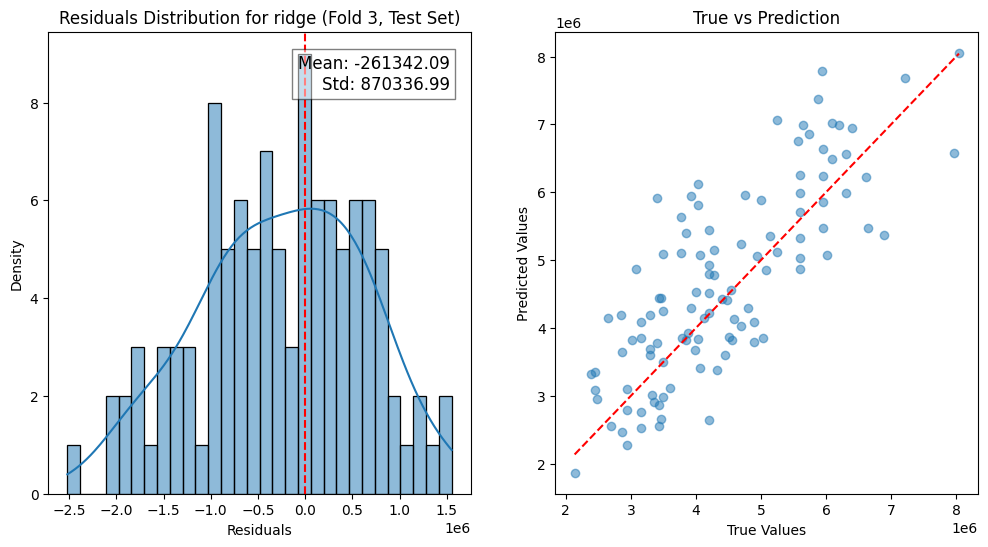

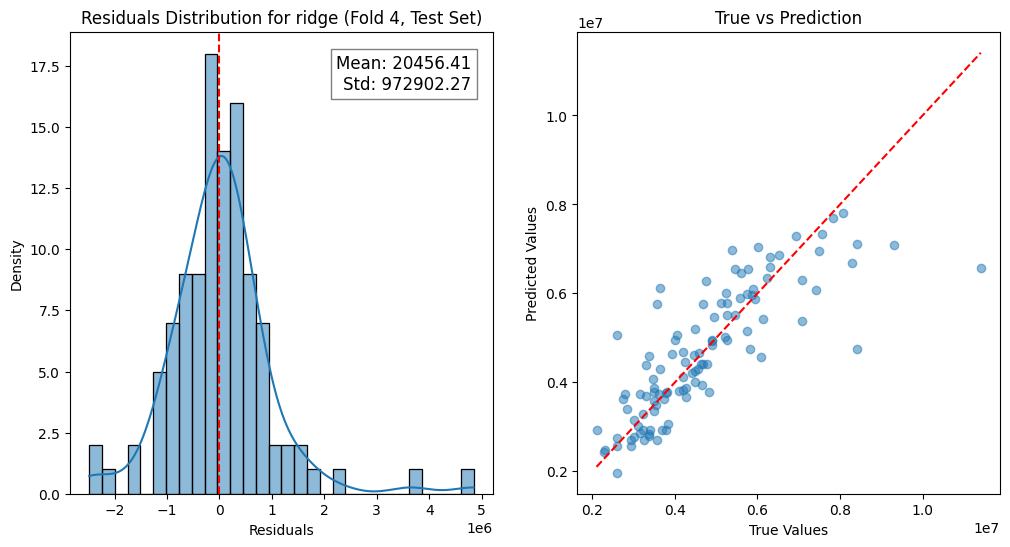

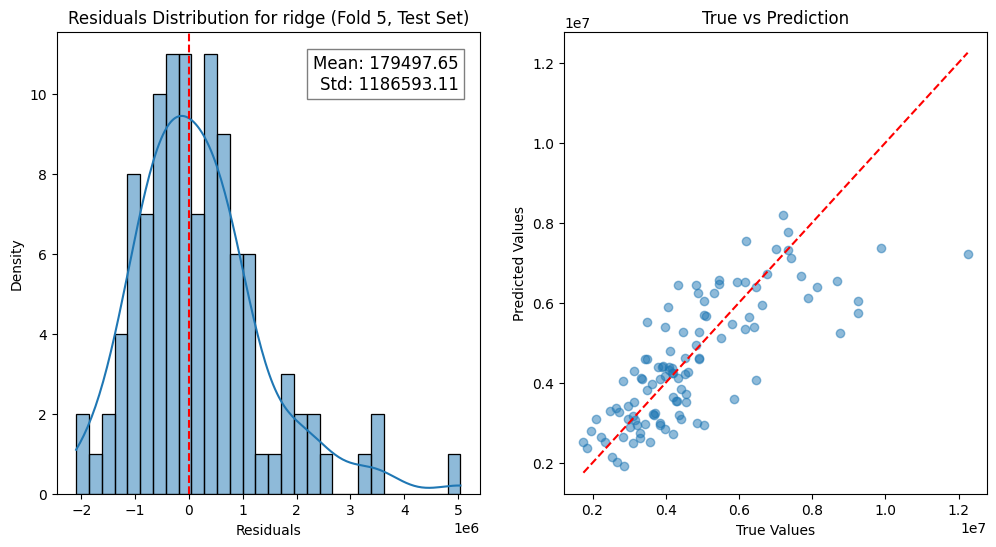

In [ ]:
# Function to plot residuals and scatter plot for each fold

model = 'ridge'
for i, (y_true_fold, y_pred_fold) in enumerate(zip(y_true_pred[model]['y_true'], y_true_pred[model]['y_pred'])):
    results.plot_residuals_and_scatter(y_true_fold, y_pred_fold, model_type=model, fold=i, dataset='Test')

***Residuals and Coefficients analyisis using a train/test split***


Visualization of the trend of the coefficients with respect to the regularization parameters. When applying techniques such as Ridge or Lasso Regression, the model coefficients change based on the regularization parameter (α).

---
**plot_coefficients_vs_alpha** function visualizes the effect of the regularization parameter alpha on model coefficients. For each alpha value a model is trained, and the coefficients are plotted.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.200e+11, tolerance: 1.197e+11



------------------------------


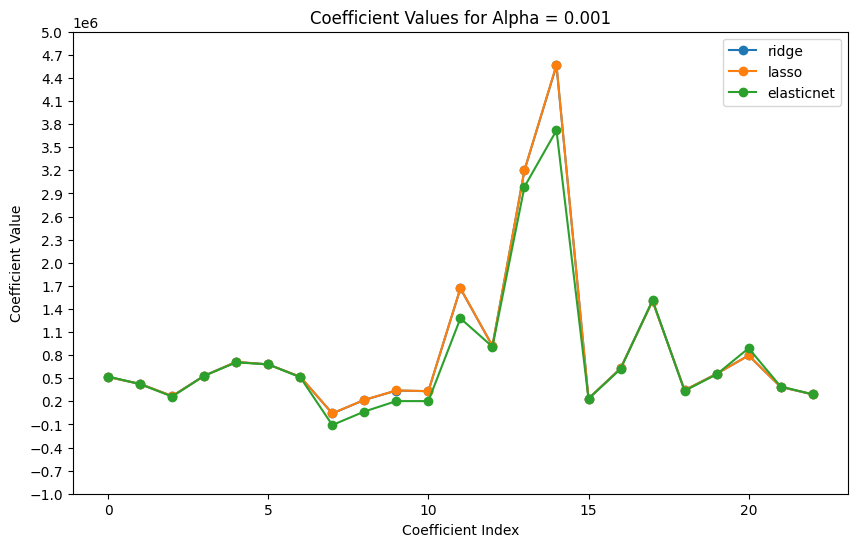

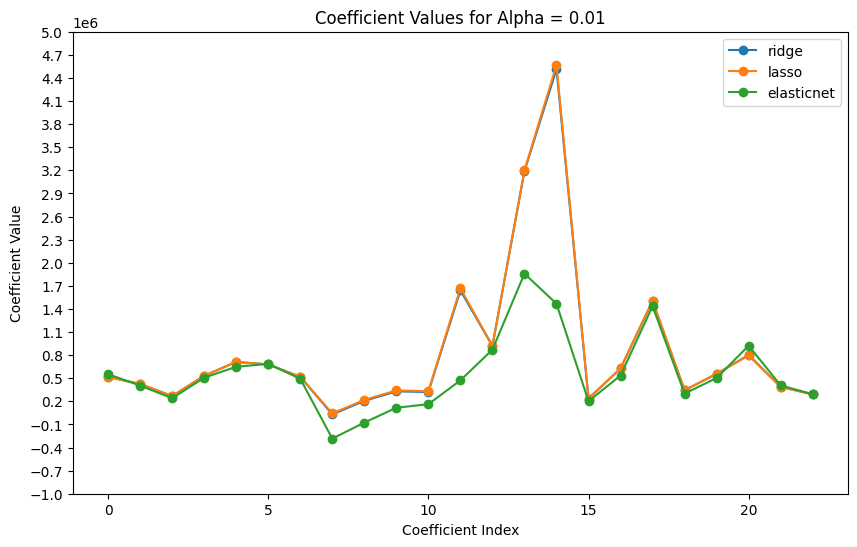

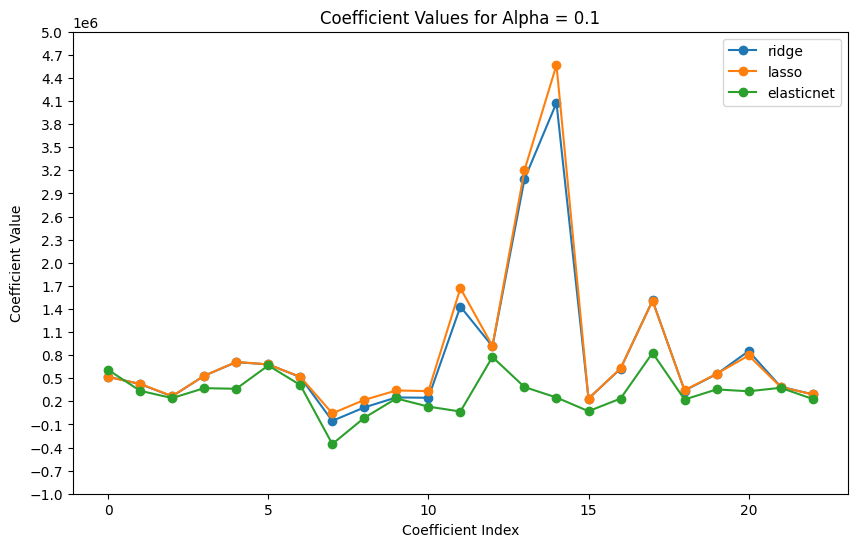

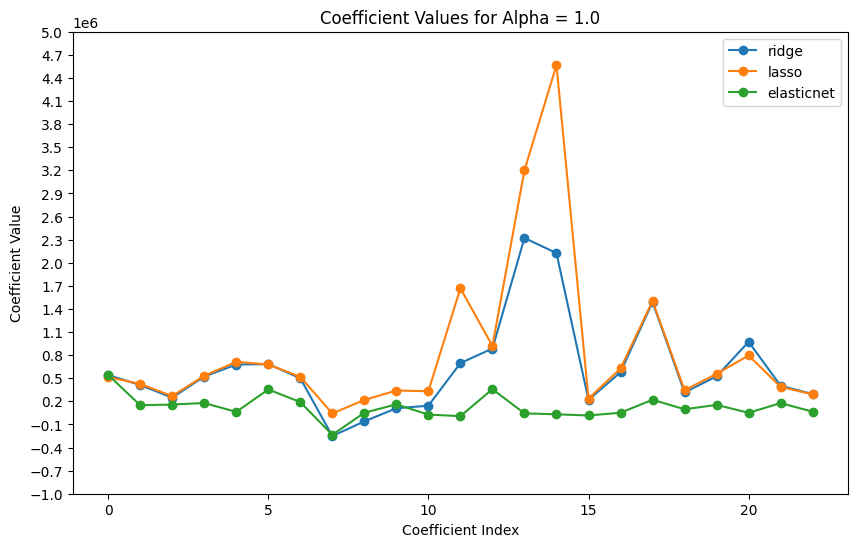

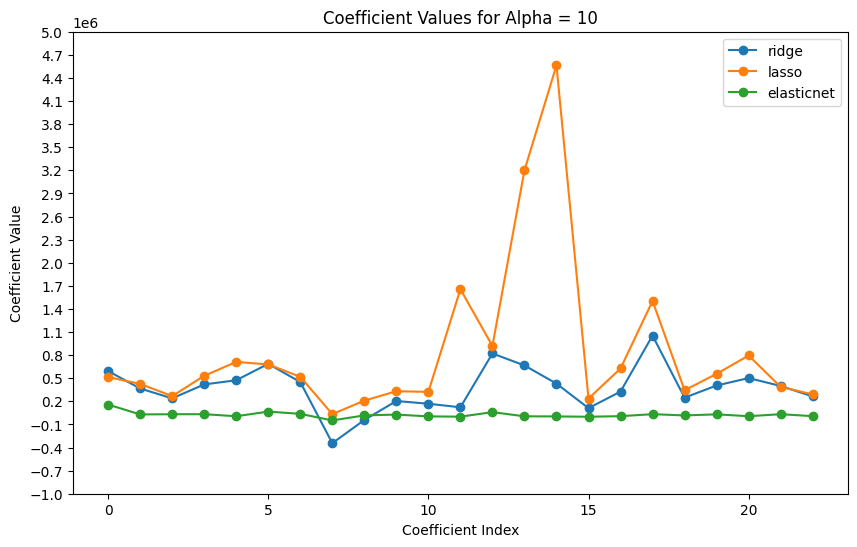

In [ ]:
# plot coefficients for regression models vs alpha values

alpha_values = [0.001, 0.01, 0.1, 1.0, 10]
results.plot_coefficients_vs_alpha(X_train_scaled, y_train, alpha_values, l1_ratio=0.5)